## Preprocess

In [55]:
import jsonlines
import pandas
import json
# Load the data from the JSON line file
with open('../data/kotlin-public.jsonl', 'r') as f:
    dataframe = pandas.DataFrame([json.loads(line) for line in f])

In [56]:
dataframe

,id,repo,revision,path,modified,prefix,suffix,archive
0,797c52,Anthonyy232/Paperize,09a6e2f031bd9a350ba17b398813d62c37982f5c,app/src/main/java/com/anthonyla/livewallpaper/...,[app/src/main/java/com/anthonyla/livewallpaper...,package com.anthonyla.livewallpaper.navigation...,}\n ...,Anthonyy232__Paperize-09a6e2f031bd9a350ba17b39...
1,35f83f,Anthonyy232/Paperize,322a10bf0c9f9bbef49f4fa75f149f198f9598a8,app/src/main/java/com/anthonyla/paperize/featu...,[app/src/main/java/com/anthonyla/paperize/core...,package com.anthonyla.paperize.feature.wallpap...,if (shouldScheduleAlar...,Anthonyy232__Paperize-322a10bf0c9f9bbef49f4fa7...
2,44457a,Anthonyy232/Paperize,37858a3e5c1bb7cfd8eb3e0bf769502fb2668db0,app/src/main/java/com/anthonyla/paperize/featu...,[app/src/main/java/com/anthonyla/paperize/App....,package com.anthonyla.paperize.feature.wallpap...,is SettingsEvent.RefreshWallpaperS...,Anthonyy232__Paperize-37858a3e5c1bb7cfd8eb3e0b...
3,a23204,Anthonyy232/Paperize,48a730e4a9be938118cae2bb66eef528fdbd7c2b,app/src/main/java/com/anthonyla/paperize/featu...,[app/src/main/java/com/anthonyla/paperize/core...,package com.anthonyla.paperize.feature.wallpap...,"inverseSurface = Color.White,\n inverse...",Anthonyy232__Paperize-48a730e4a9be938118cae2bb...
4,0fa786,Anthonyy232/Paperize,5eb55575b4a33d5f9206780ff5e1316f13354de6,app/src/main/java/com/anthonyla/paperize/featu...,[app/src/main/java/com/anthonyla/paperize/App....,package com.anthonyla.paperize.feature.wallpap...,"),\n enterTransition = ...",Anthonyy232__Paperize-5eb55575b4a33d5f9206780f...
...,...,...,...,...,...,...,...,...
395,7e5c05,xebia-functional/xef,cc264d2383f63569c9fee1446a9a655e91b624ca,kotlin/src/commonMain/kotlin/com/xebia/functio...,[kotlin/src/commonMain/kotlin/com/xebia/functi...,package com.xebia.functional.prompt\n\nimport ...,\ndata class HumanMessage(override val content...,xebia-functional__xef-cc264d2383f63569c9fee144...
396,6c96f1,xebia-functional/xef,d46e052218799ad1b8941eb7001af4d1c3063473,core/src/commonMain/kotlin/com/xebia/functiona...,[core/src/commonMain/kotlin/com/xebia/function...,package com.xebia.functional.xef.llm\n\nimport...,"scope,\n functions,\n { json -...",xebia-functional__xef-d46e052218799ad1b8941eb7...
397,430599,xebia-functional/xef,e42d443fff42efaed67c27aaf9e46aba484be9d9,core/src/commonMain/kotlin/com/xebia/functiona...,[core/src/commonMain/kotlin/com/xebia/function...,package com.xebia.functional.xef.metrics\n\nim...,}\n\n override suspend fun assistantCreated...,xebia-functional__xef-e42d443fff42efaed67c27aa...
398,d2b778,xebia-functional/xef,fe88efd640047ad0435362b1e744543c5f304b76,gpt4all-kotlin/src/jvmMain/kotlin/com/xebia/fu...,[core/src/commonMain/kotlin/com/xebia/function...,package com.xebia.functional.gpt4all\n\nimport...,"\n operator fun invoke(\n url: String,...",xebia-functional__xef-fe88efd640047ad0435362b1...


In [59]:
import os
SEPARATOR_COMMENT = "\n/**<FIM>*/\n"
DATA_ROOT = "../data/repositories-kotlin-public/"



def extract_original_code_from_row(row: pandas.Series) -> str:
    """
    Extract the original code from the file path.
    """
    repo_path = os.path.join(DATA_ROOT, "-".join([row["repo"].replace("/", "__"), row['revision']]))
    file_path = repo_path + "/" + row['path']
    with open(file_path, 'r') as file:
        content = file.read()
    return content

dataframe['original_code'] = dataframe.apply(extract_original_code_from_row, axis=1)
dataframe['incomplete_code'] = dataframe.apply(lambda row: SEPARATOR_COMMENT.join([row['prefix'], row['suffix']]), axis=1)


In [60]:
import diff_match_patch

def extract_diff_from_original_code_and_incomplete_code(row) -> str:
    """
    Extract the diff from the original code.
    """
    dmp = diff_match_patch.diff_match_patch()
    original_code = row['original_code']
    incomplete_code = row['incomplete_code']
    
    diffs = dmp.diff_lineMode(original_code, incomplete_code, deadline=None)
    # Convert the diffs to a single diff string
    diffs = "\n".join([diff[1] for diff in diffs if diff[0] != 0])
    return diffs

def extract_patch_from_original_code_and_incomplete_code(row) -> str:
    """
    Extract the patch from the original code.
    """
    dmp = diff_match_patch.diff_match_patch()
    original_code = row['original_code']
    incomplete_code = row['incomplete_code']
    
    diffs = dmp.patch_make(original_code, incomplete_code)
    # Convert the patches to a single patch string
    patches = dmp.patch_toText(diffs)
    return patches


In [61]:
for index, row in dataframe.iterrows():
    output_root = "../samples/"  
    repo_revision = "-".join([row["repo"].replace("/", "__"), row['revision']])
    dir_name = os.path.join(output_root, repo_revision)
    os.makedirs(dir_name, exist_ok=True)
    original_file_path = os.path.join(dir_name, "original.kt")
    incomplete_file_path = os.path.join(dir_name, "incomplete.kt")
    diff_file_path = os.path.join(dir_name, "diff.diff")
    patch_file_path = os.path.join(dir_name, "patch.patch")
    
    
    with open(original_file_path, 'w') as original_file:
        original_file.write(row['original_code'])
    with open(incomplete_file_path, 'w') as incomplete_file:
        incomplete_file.write(row['incomplete_code'])
    with open(diff_file_path, 'w') as diff_file:
        diff_file.write(extract_diff_from_original_code_and_incomplete_code(row))
    with open(patch_file_path, 'w') as patch_file:
        patch_file.write(extract_patch_from_original_code_and_incomplete_code(row))
    
    dataframe.at[index, 'diff'] = extract_diff_from_original_code_and_incomplete_code(row)
    dataframe.at[index, 'patch'] = extract_patch_from_original_code_and_incomplete_code(row)

        
        


## Syntax tree analysis

In [62]:
# Let's create a simple example to demonstrate the tree-sitter query matching
import tree_sitter
from tree_sitter_languages import get_language
# Sample Kotlin code
kotlin_code = """
class Person(val name: String) {
    var age: Int = 0
    
    fun getInfo(): String {
        return "Name: $name, Age: $age"
    }
    
    // This is a comment
    @Override
    fun toString() = "Person(name=$name)"
}
"""

# Create a parser
parser = tree_sitter.Parser()
parser.set_language(get_language("kotlin"))

# Parse the code
tree = parser.parse(bytes(kotlin_code, "utf8"))

# Print the syntax tree
print(tree.root_node.sexp())

(source_file (class_declaration name: (type_identifier) primary_constructor: (primary_constructor parameters: (class_parameter (simple_identifier) (user_type (type_identifier)))) body: (class_body (property_declaration variable: (variable_declaration (simple_identifier) (user_type (type_identifier))) expression: (integer_literal)) (function_declaration name: (simple_identifier) parameters: (function_value_parameters) return_type: (user_type (type_identifier)) body: (function_body (statements (jump_expression (string_literal (interpolated_identifier) (interpolated_identifier)))))) (line_comment) (function_declaration modifiers: (modifiers (annotation (user_type (type_identifier)))) name: (simple_identifier) parameters: (function_value_parameters) body: (function_body (string_literal (interpolated_identifier)))))))


In [63]:
def highlight_matches(code: str, query_string: str):
    """
    Highlight matches from a tree-sitter query in the given code
    """
    # Create a query
    language = get_language("kotlin")
    query = language.query(query_string)
    
    # Get matches
    tree = parser.parse(bytes(code, "utf8"))
    matches = query.captures(tree.root_node)
    if not matches:
        print("No matches found.")
        return
    
    
    # Print matches with their capture types
    for match in matches:
        print(match)

In [64]:
# Let's try some specific queries

# Find all function declarations
function_query = """
(function_declaration 
    . (simple_identifier) @function_name) @function
"""
print("Function declarations:")
highlight_matches(kotlin_code, function_query)

# Find class declarations
class_query = """(class_declaration
    (simple_identifier) @class_name) @class
"""

# Find class properties
property_query = """
(class_parameter
    (simple_identifier) @property)
(class_body
    (property_declaration
        (variable_declaration
            (simple_identifier) @property)))
"""
print("\nProperties:")
highlight_matches(kotlin_code, property_query)

Function declarations:
(<Node type=function_declaration, start_point=(4, 4), end_point=(6, 5)>, 'function')
(<Node type=simple_identifier, start_point=(4, 8), end_point=(4, 15)>, 'function_name')
(<Node type=function_declaration, start_point=(9, 4), end_point=(10, 41)>, 'function')

Properties:
(<Node type=simple_identifier, start_point=(1, 17), end_point=(1, 21)>, 'property')
(<Node type=simple_identifier, start_point=(2, 8), end_point=(2, 11)>, 'property')


In [65]:
# Function to analyze package and import relationships
def analyze_package_imports(code: str) -> tuple[str, list[str]]:
    """
    Analyze a Kotlin file to extract its package and imports,
    returning the package name and list of import statements
    """
    # Query to capture package and import identifiers
    query_str = """
    (package_header
        (identifier) @package)
        
    (import_header
        (identifier) @import)
    """
    
    # Parse the code
    language = get_language("kotlin")
    tree = parser.parse(bytes(code, "utf8"))
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    if not matches:
        print("No matches found.")
        return "", []
    package_name = ""
    imports = []
    
    for (node, node_name) in matches:
        if node_name == "package":
            package_name= node.text.decode("utf-8")
        elif node_name == "import":
            imports.append(node.text.decode("utf-8"))

    return package_name, imports

def check_same_repository_imports(package_name: str, imports: list[str]) -> list[str]:
    """
    Check which imports are from the same repository as the package
    by comparing their root package names
    """
    # Get the root package (first component)
    root_package = package_name.split('.')[0]
    
    # Find imports that start with the same root package
    same_repo_imports = [
        imp for imp in imports
        if imp.split('.')[0] == root_package
    ]
    
    return same_repo_imports

# Test with the sample code
sample_kotlin = '''package fe.linksheet.module.resolver
import android.content.Context
import android.content.Intent
import android.content.IntentFilter
import android.content.IntentFilter.AuthorityEntry
import android.content.pm.PackageManager
import android.content.pm.ResolveInfo
import android.content.pm.queryIntentActivitiesCompat
import android.net.Uri
import fe.linksheet.util.BitFlagUtil
import fe.linksheet.util.LinkSheetCompat
'''

package_name, imports = analyze_package_imports(sample_kotlin)
print(f"Package: {package_name}")
print("\nImports:")
for imp in imports:
    print(f"  {imp}")

same_repo_imports = check_same_repository_imports(package_name, imports)
print("\nImports from same repository:")
for imp in same_repo_imports:
    print(f"  {imp}")

Package: fe.linksheet.module.resolver

Imports:
  android.content.Context
  android.content.Intent
  android.content.IntentFilter
  android.content.IntentFilter.AuthorityEntry
  android.content.pm.PackageManager
  android.content.pm.ResolveInfo
  android.content.pm.queryIntentActivitiesCompat
  android.net.Uri
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat

Imports from same repository:
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat


## Token-level Analysis

In [66]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("JetBrains/Mellum-4b-sft-kotlin")


/Users/minhna1112/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [67]:
print(tokenizer.encode(kotlin_code))

[225, 925, 15970, 34, 841, 517, 52, 1269, 35, 339, 225, 247, 247, 247, 924, 5522, 52, 1410, 306, 369, 225, 225, 247, 247, 247, 4131, 779, 1243, 3161, 1269, 339, 225, 247, 247, 247, 247, 247, 247, 247, 545, 327, 574, 52, 427, 380, 38, 14369, 52, 427, 471, 28, 225, 247, 247, 247, 367, 225, 225, 247, 247, 247, 521, 1461, 432, 283, 5617, 225, 247, 247, 247, 583, 2944, 225, 247, 247, 247, 4131, 17956, 403, 306, 327, 9512, 34, 380, 5050, 380, 2324, 225, 119, 225]


In [68]:
def code_to_tokens(code: str | list[str]) -> list[int]:
    """
    Convert code to tokens using the tokenizer
    """
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    if isinstance(code, list):
        return [token for snippet in cleaned_code for token in tokenizer.encode(snippet)]
    return tokenizer.encode(cleaned_code)

dataframe['num_prefix_tokens'] = dataframe['prefix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_suffix_tokens'] = dataframe['suffix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_diff_tokens'] = dataframe['diff'].apply(lambda x : len(code_to_tokens(x)))

In [69]:
dataframe[['num_prefix_tokens', 'num_suffix_tokens', 'num_diff_tokens']].head()

,num_prefix_tokens,num_suffix_tokens,num_diff_tokens
0,691,121,348
1,1506,892,560
2,1659,510,308
3,1388,657,329
4,2317,1265,840


Text(0, 0.5, 'Frequency')

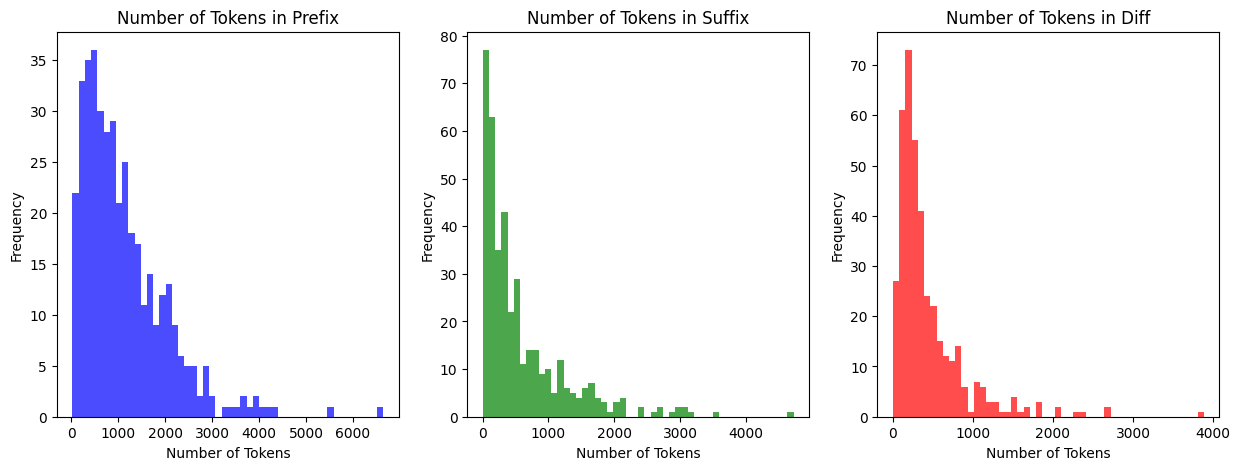

In [70]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

In [71]:
def remove_comments_nodes(code: str)->str:
    """
    Remove comments from the code using tree-sitter
    """
    language = get_language("kotlin")
    parser = tree_sitter.Parser()
    parser.set_language(language)
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    # Parse the code
    tree = parser.parse(bytes(cleaned_code, "utf8"))

    # Query to find comment nodes
    query_str = """
    (line_comment) @comment
    (multiline_comment) @comment
    """
    
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    
    # Remove comment nodes from the code
    
    for match in matches:
        node = match[0]
        cleaned_code = cleaned_code[:node.start_byte] + cleaned_code[node.end_byte:]

    return cleaned_code

dataframe['prefix_without_comments'] = dataframe['prefix'].apply(
    remove_comments_nodes
)

dataframe['suffix_without_comments'] = dataframe['suffix'].apply(
    remove_comments_nodes
)
dataframe['diff_without_comments'] = dataframe['diff'].apply(
    remove_comments_nodes
)



Text(0.5, 1.0, 'Number of Tokens in Diff')

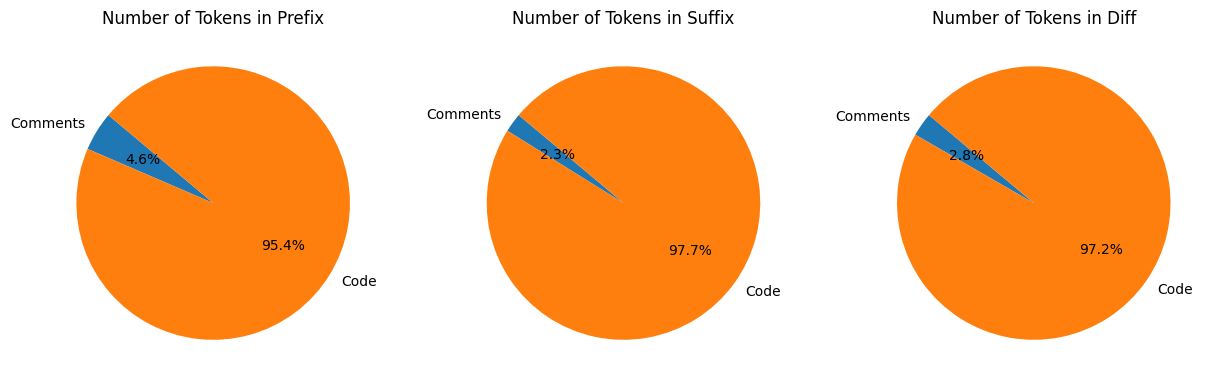

In [72]:
dataframe["num_prefix_tokens_without_comments"] = dataframe['prefix_without_comments'].apply(lambda x : len(code_to_tokens(x)))
dataframe["num_suffix_tokens_without_comments"] = dataframe['suffix_without_comments'].apply(lambda x : len(code_to_tokens(x)))
dataframe["num_diff_tokens_without_comments"] = dataframe['diff_without_comments'].apply(lambda x : len(code_to_tokens(x)))

# plot 3 pie charts of the number of tokens  between code and comments (original - code) in prefix, suffix, and diff

import matplotlib.pyplot as plt

labels = ['Comments', 'Code']
prefix_sizes = [
    dataframe['num_prefix_tokens'].sum() - dataframe['num_prefix_tokens_without_comments'].sum(),
    dataframe['num_prefix_tokens_without_comments'].sum()
]
suffix_sizes = [
    dataframe['num_suffix_tokens'].sum() - dataframe['num_suffix_tokens_without_comments'].sum(),
    dataframe['num_suffix_tokens_without_comments'].sum()
]
diff_sizes = [
    dataframe['num_diff_tokens'].sum() - dataframe['num_diff_tokens_without_comments'].sum(),
    dataframe['num_diff_tokens_without_comments'].sum()
]
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.pie(prefix_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Prefix')
plt.subplot(1, 3, 2)
plt.pie(suffix_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Suffix')
plt.subplot(1, 3, 3)
plt.pie(diff_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Diff')


Text(0, 0.5, 'Frequency')

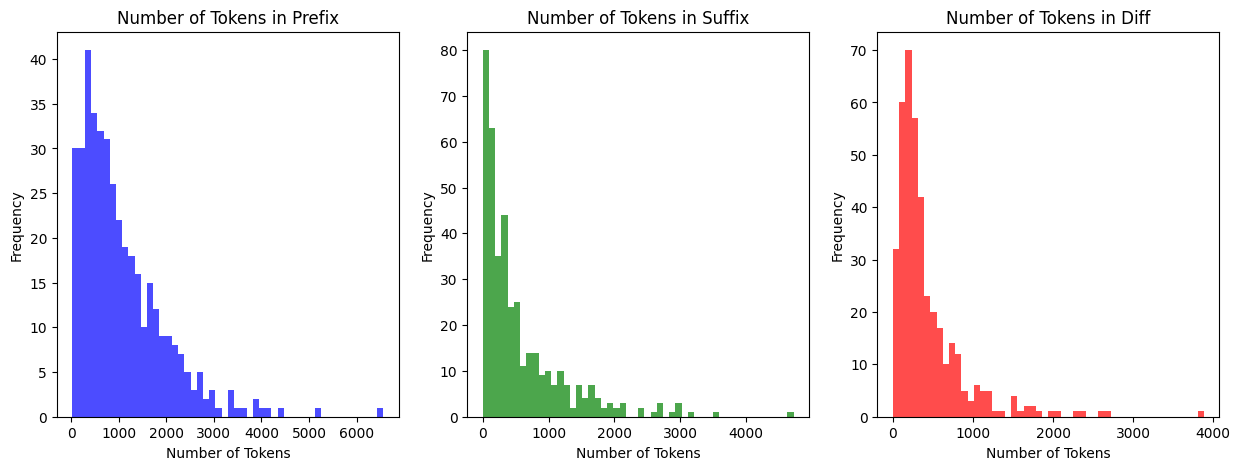

In [73]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff (after removing comments)
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens_without_comments'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens_without_comments'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens_without_comments'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

In [ ]:
# Function to analyze package and import relationships
from tree_sitter import Node
from tree_sitter_languages import get_language, get_parser
def analyze_package_imports(code: str) -> tuple[str, list[Node]]:
    """
    Analyze a Kotlin file to extract its package and imports,
    returning the package name and list of import statements
    """
    # Query to capture package and import identifiers
    query_str = """
    (package_header
        (identifier) @package)
        
    (import_header
        (identifier) @import)
    """
    parser = get_parser("kotlin")
    # Parse the code
    language = get_language("kotlin")
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    tree = parser.parse(bytes(cleaned_code, "utf8"))
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    if not matches:
        print("No matches found.")
        return "", []
    package_name = ""
    imports = []
    
    for (node, node_name) in matches:
        if node_name == "package":
            package_name= node.text.decode("utf-8")
        elif node_name == "import":
            imports.append(node)

    return package_name, imports

def check_same_repository_imports(package_name: str, imports: list[Node]) -> list[Node]:
    """
    Check which imports are from the same repository as the package
    by comparing their root package names
    """
    # Get the root package (first component)
    root_package = package_name.split('.')[0]
    
    # Find imports that start with the same root package
    same_repo_imports = [
        imp for imp in imports
        if imp.text.decode("utf-8").split('.')[0] == root_package
    ]
    external_imports = [
        imp for imp in imports
        if imp.text.decode("utf-8").split('.')[0] != root_package
    ]

    return same_repo_imports, external_imports

# Test with the sample code
sample_kotlin = '''package fe.linksheet.module.resolver
import android.content.Context
import android.content.Intent
import android.content.IntentFilter
import android.content.IntentFilter.AuthorityEntry
import android.content.pm.PackageManager
import android.content.pm.ResolveInfo
import android.content.pm.queryIntentActivitiesCompat
import android.net.Uri
import fe.linksheet.util.BitFlagUtil
import fe.linksheet.util.LinkSheetCompat
'''

package_name, imports = analyze_package_imports(sample_kotlin)
print(f"Package: {package_name}")

same_repo_imports, external_imports = check_same_repository_imports(package_name, imports)
print("\nImports from same repository:")

def remove_import_nodes(code: str, import_nodes: list[Node]) -> str:
    """
    Remove import statements from the code using tree-sitter
    """
    for node in import_nodes:
        code = code[:node.start_byte] + code[node.end_byte:]

    return code



for imp in same_repo_imports:
    print(f"  {imp.text.decode('utf-8')}")

print("\nExternal Imports:")
for imp in external_imports:
    print(f"  {imp.text.decode('utf-8')}")


# A function to at the same time identify pakage name, extract in-repository and external imports, and remove import nodes from prefix
def analyze_and_clean_imports(code: str) -> tuple[str, list[str], list[str], str]:
    """
    Analyze the code to extract package name, in-repository imports, external imports,
    and return the cleaned code without import statements.
    """
    package_name, imports = analyze_package_imports(code)
    same_repo_imports, external_imports = check_same_repository_imports(package_name, imports)
    cleaned_code = remove_import_nodes(code, same_repo_imports)
    return package_name, same_repo_imports, external_imports, cleaned_code

package_name, same_repo_imports, external_imports, cleaned_code = analyze_and_clean_imports(sample_kotlin)
print(f"Package: {package_name}")
print("\nImports from same repository:")
for imp in same_repo_imports:
    print(f"  {imp.text.decode('utf-8')}")
print("\nExternal Imports:")
for imp in external_imports:
    print(f"  {imp.text.decode('utf-8')}") 
print("\nCleaned Code:")


Package: fe.linksheet.module.resolver

Imports from same repository:
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat

External Imports:
  android.content.Context
  android.content.Intent
  android.content.IntentFilter
  android.content.IntentFilter.AuthorityEntry
  android.content.pm.PackageManager
  android.content.pm.ResolveInfo
  android.content.pm.queryIntentActivitiesCompat
  android.net.Uri
Package: fe.linksheet.module.resolver

Imports from same repository:
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat

External Imports:
  android.content.Context
  android.content.Intent
  android.content.IntentFilter
  android.content.IntentFilter.AuthorityEntry
  android.content.pm.PackageManager
  android.content.pm.ResolveInfo
  android.content.pm.queryIntentActivitiesCompat
  android.net.Uri

Cleaned Code:


In [77]:
for index, row in dataframe.iterrows():
    package_name, same_repo_imports, external_imports, cleaned_code = analyze_and_clean_imports(row.prefix)
    dataframe.at[index, 'package_name'] = package_name
    dataframe.at[index, 'same_repo_imports'] = [imp.text.decode('utf-8') for imp in same_repo_imports]
    dataframe.at[index, 'external_imports'] = [imp.text.decode('utf-8') for imp in external_imports]
    dataframe.at[index, 'prefix_without_imports'] = cleaned_code

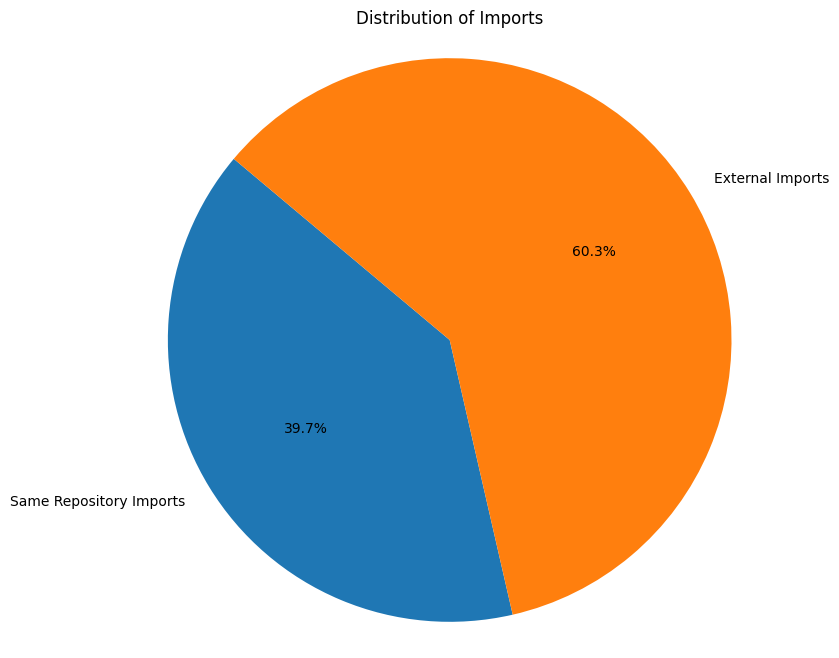

In [78]:
# pie charts of the number of imports in same repository and external imports
import matplotlib.pyplot as plt
labels = ['Same Repository Imports', 'External Imports']
same_repo_counts = dataframe['same_repo_imports'].apply(len).sum()
external_counts = dataframe['external_imports'].apply(len).sum()
sizes = [same_repo_counts, external_counts]
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Imports')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

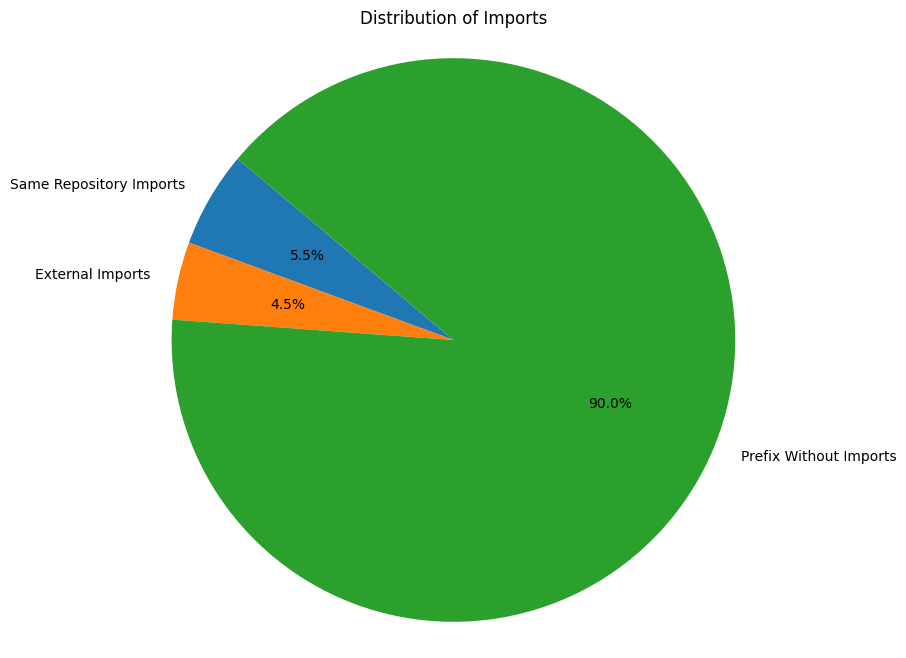

In [108]:
# pie charts of the number of tokens of imports in same repository and external imports, and the prefix without imports
import matplotlib.pyplot as plt
labels = ['Same Repository Imports', 'External Imports', 'Prefix Without Imports']
same_repo_counts = dataframe['same_repo_imports'].apply(lambda x: len(code_to_tokens(x))).sum()
external_counts = dataframe['external_imports'].apply(lambda x: len(code_to_tokens(x))).sum()
prefix_counts = dataframe['prefix_without_imports'].apply(lambda x: len(code_to_tokens(x))).sum()
sizes = [same_repo_counts, external_counts, prefix_counts]
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Imports')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Text(0, 0.5, 'Frequency')

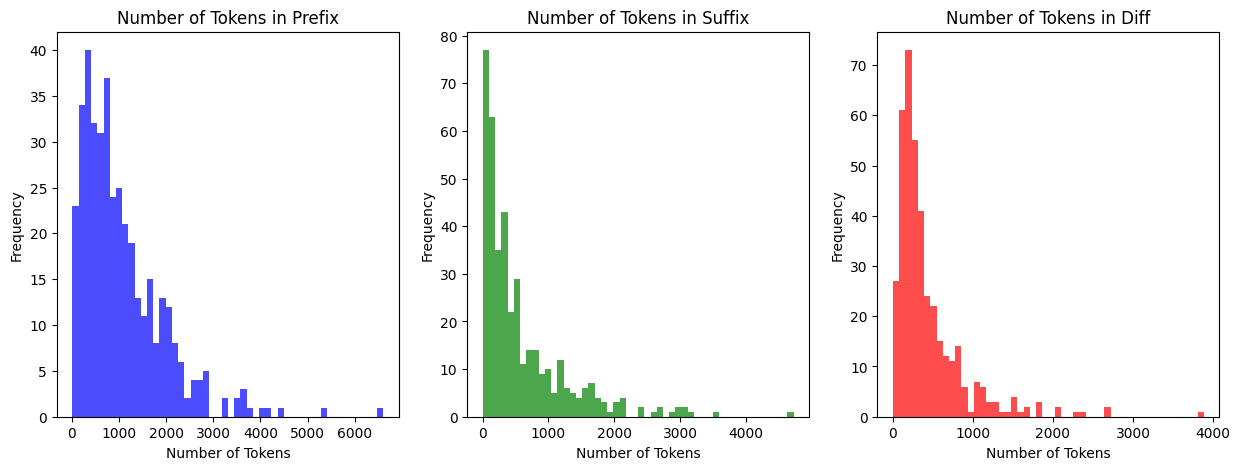

In [79]:
# 3 histograms of the number of tokens in prefix (after removing imports), suffix, and diff 
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['prefix_without_imports'].apply(lambda x: len(code_to_tokens(x))), bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

In [80]:
dataframe.head()

,id,repo,revision,path,modified,prefix,suffix,archive,original_code,incomplete_code,...,prefix_without_comments,suffix_without_comments,diff_without_comments,num_prefix_tokens_without_comments,num_suffix_tokens_without_comments,num_diff_tokens_without_comments,package_name,same_repo_imports,external_imports,prefix_without_imports
0,797c52,Anthonyy232/Paperize,09a6e2f031bd9a350ba17b398813d62c37982f5c,app/src/main/java/com/anthonyla/livewallpaper/...,[app/src/main/java/com/anthonyla/livewallpaper...,package com.anthonyla.livewallpaper.navigation...,}\n ...,Anthonyy232__Paperize-09a6e2f031bd9a350ba17b39...,package com.anthonyla.livewallpaper.navigation...,package com.anthonyla.livewallpaper.navigation...,...,package com.anthonyla.livewallpaper.navigation...,}\n ...,DropdownMenu(\n ...,687,121,348,com.anthonyla.livewallpaper.navigation,[com.anthonyla.livewallpaper.R],"[androidx.compose.material.icons.Icons, androi...",package com.anthonyla.livewallpaper.navigation...
1,35f83f,Anthonyy232/Paperize,322a10bf0c9f9bbef49f4fa75f149f198f9598a8,app/src/main/java/com/anthonyla/paperize/featu...,[app/src/main/java/com/anthonyla/paperize/core...,package com.anthonyla.paperize.feature.wallpap...,if (shouldScheduleAlar...,Anthonyy232__Paperize-322a10bf0c9f9bbef49f4fa7...,package com.anthonyla.paperize.feature.wallpap...,package com.anthonyla.paperize.feature.wallpap...,...,package com.anthonyla.paperize.feature.wallpap...,if (shouldScheduleAlar...,LifecycleEventEffect(Lifecycle.Eve...,1506,892,560,com.anthonyla.paperize.feature.wallpaper.prese...,[com.anthonyla.paperize.core.SettingsConstants...,"[android.Manifest, android.animation.ObjectAni...",package com.anthonyla.paperize.feature.wallpap...
2,44457a,Anthonyy232/Paperize,37858a3e5c1bb7cfd8eb3e0bf769502fb2668db0,app/src/main/java/com/anthonyla/paperize/featu...,[app/src/main/java/com/anthonyla/paperize/App....,package com.anthonyla.paperize.feature.wallpap...,is SettingsEvent.RefreshWallpaperS...,Anthonyy232__Paperize-37858a3e5c1bb7cfd8eb3e0b...,package com.anthonyla.paperize.feature.wallpap...,package com.anthonyla.paperize.feature.wallpap...,...,package com.anthonyla.paperize.feature.wallpap...,is SettingsEvent.RefreshWallpaperS...,is SettingsEvent.SetWallpaperInter...,1659,510,308,com.anthonyla.paperize.feature.wallpaper.prese...,[com.anthonyla.paperize.core.SettingsConstants...,"[androidx.compose.runtime.getValue, androidx.c...",package com.anthonyla.paperize.feature.wallpap...
3,a23204,Anthonyy232/Paperize,48a730e4a9be938118cae2bb66eef528fdbd7c2b,app/src/main/java/com/anthonyla/paperize/featu...,[app/src/main/java/com/anthonyla/paperize/core...,package com.anthonyla.paperize.feature.wallpap...,"inverseSurface = Color.White,\n inverse...",Anthonyy232__Paperize-48a730e4a9be938118cae2bb...,package com.anthonyla.paperize.feature.wallpap...,package com.anthonyla.paperize.feature.wallpap...,...,package com.anthonyla.paperize.feature.wallpap...,"inverseSurface = Color.White,\n inverse...",private val AmoledDarkColors = darkColorScheme...,1388,613,329,com.anthonyla.paperize.feature.wallpaper.prese...,[],"[android.app.Activity, android.os.Build, andro...",package com.anthonyla.paperize.feature.wallpap...
4,0fa786,Anthonyy232/Paperize,5eb55575b4a33d5f9206780ff5e1316f13354de6,app/src/main/java/com/anthonyla/paperize/featu...,[app/src/main/java/com/anthonyla/paperize/App....,package com.anthonyla.paperize.feature.wallpap...,"),\n enterTransition = ...",Anthonyy232__Paperize-5eb55575b4a33d5f9206780f...,package com.anthonyla.paperize.feature.wallpap...,package com.anthonyla.paperize.feature.wallpap...,...,package com.anthonyla.paperize.feature.wallpap...,"),\n enterTransition = ...",route = NavScreens.AlbumView.route...,2306,1265,840,com.anthonyla.paperize.feature.wallpaper.prese...,"[com.anthonyla.paperize.data.Contact, com.anth...",[androidx.compose.animation.AnimatedContentTra...,package com.anthonyla.paperize.feature.wallpap...


### Localize Completion Point

In [135]:
from tree_sitter import Node
from tree_sitter_languages import get_language, get_parser
# using tree-sitter to find multi-line comment nodes in the diff
import re

def detect_completion_point(row) -> tuple[int, int]:
    """
    Detect the completion point by taking the end point of the prefix.
    """
    parser = get_parser("kotlin")
    tree = parser.parse(bytes(row["prefix"], "utf8"))
    return tree.root_node.end_point

def localize_outer_symbol_from_completion_point(row: pandas.Series) -> Node:
    """
    Localize the completion point by find the closet identified symbol that contains the completion point.
    """
    parser = get_parser("kotlin")
    incomplete_code = row["incomplete_code"].replace(SEPARATOR_COMMENT, "")
    tree = parser.parse(bytes(incomplete_code, "utf8"))
    with open("../kotlin_functions.scm", "r") as f:
        query_str = f.read()
    query = get_language("kotlin").query(query_str)

    matches = query.captures(tree.root_node)
    
    # sort matches by their start point (start point is a tuple (row, column))
    sorted_matches = sorted(matches, key=lambda match: match[0].start_point)
    completion_point = detect_completion_point(row)
    print(completion_point)
    candidate_node = sorted_matches.pop(0)[0] if sorted_matches else None

    while sorted_matches and candidate_node.start_point[0] <= completion_point[0] and completion_point[0] <= candidate_node.end_point[0]:
        next_node = sorted_matches.pop(0)[0]
        if next_node.start_point[0] <= completion_point[0] and completion_point[0] <= next_node.end_point[0]:
            candidate_node = next_node

    return candidate_node

In [136]:
localize_outer_symbol_from_completion_point(dataframe.iloc[0]).text.decode("utf-8")

(44, 33)


'DropdownMenuItem(\n                        text = { Text(stringResource(R.string.dropdownmenu_settings)) },\n                        onClick = {\n                            navController.navigate(SettingsNavScreens.Settings.route) {\n                                p                            }\n                        }\n                    )'

In [110]:
dataframe.iloc[0]# find the position of the first function declaration in the incomplete code

id                                                                               797c52
repo                                                               Anthonyy232/Paperize
revision                                       09a6e2f031bd9a350ba17b398813d62c37982f5c
path                                  app/src/main/java/com/anthonyla/livewallpaper/...
modified                              ['app/src/main/java/com/anthonyla/livewallpape...
prefix                                package com.anthonyla.livewallpaper.navigation...
suffix                                                            }\n               ...
archive                               Anthonyy232__Paperize-09a6e2f031bd9a350ba17b39...
original_code                         package com.anthonyla.livewallpaper.navigation...
incomplete_code                       package com.anthonyla.livewallpaper.navigation...
diff                                                  DropdownMenu(\n               ...
patch                           

In [82]:
import pandas as pd
dataframe  = pd.read_csv("../data/kotlin_public_analyzed.csv")

In [48]:
err_diff = dataframe[dataframe['diff'].apply(lambda x: len(find_multiline_comments_in_diff(x)) ==0 )]

NameError: name 'SEPARATOR_COMMENT' is not defined

In [45]:
err_diff 

,id,repo,revision,path,modified,prefix,suffix,archive,original_code,incomplete_code,...,prefix_without_comments,suffix_without_comments,diff_without_comments,num_prefix_tokens_without_comments,num_suffix_tokens_without_comments,num_diff_tokens_without_comments,package_name,same_repo_imports,external_imports,prefix_without_imports
28,82e152,KotatsuApp/Kotatsu,a8a65e953f8be92a3fa022ecc935547e130fd4c8,app/src/main/java/org/koitharu/kotatsu/setting...,['app/src/main/java/org/koitharu/kotatsu/Kotat...,package org.koitharu.kotatsu.settings\n\nimpor...,},KotatsuApp__Kotatsu-a8a65e953f8be92a3fa022ecc9...,package org.koitharu.kotatsu.settings\n\nimpor...,package org.koitharu.kotatsu.settings\n\nimpor...,...,package org.koitharu.kotatsu.settings\n\nimpor...,},}\n\t\n/**<FIM>*/\n},1845,1,10,org.koitharu.kotatsu.settings,"['org.koin.android.ext.android.inject', 'org.k...","['android.content.Intent', 'android.content.Sh...",package org.koitharu.kotatsu.settings\n\nimpor...
80,e8e177,aivanovski/keepassvault,118aec118260d23147f565b71e0fdb8282dfa8ea,app/src/main/kotlin/com/ivanovsky/passnotes/da...,['app/src/main/java/com/ivanovsky/passnotes/da...,package com.ivanovsky.passnotes.data.entity\n\...,*/\n @Parcelize\n data class SshCre...,aivanovski__keepassvault-118aec118260d23147f56...,package com.ivanovsky.passnotes.data.entity\n\...,package com.ivanovsky.passnotes.data.entity\n\...,...,package com.ivanovsky.passnotes.data.entity\n\...,*/\n @Parcelize\n data class SshCre...,\n\n \n @Parcelize\n data class SshCr...,196,104,99,com.ivanovsky.passnotes.data.entity,[],"['android.os.Parcelable', 'kotlinx.parcelize.P...",package com.ivanovsky.passnotes.data.entity\n\...
100,7cea22,cliuff/boundo,2605c8b63ebc7513eefc4499c19b29d32981a6d3,api_viewing/src/main/kotlin/com/madness/collis...,['api_viewing/src/main/kotlin/com/madness/coll...,/*\n * Copyright 2024 Clifford Liu\n *\n * Lic...,overflow = TextOverflow.El...,cliuff__boundo-2605c8b63ebc7513eefc4499c19b29d...,/*\n * Copyright 2024 Clifford Liu\n *\n * Lic...,/*\n * Copyright 2024 Clifford Liu\n *\n * Lic...,...,\n\npackage com.madness.collision.unit.api_vie...,overflow = TextOverflow.El...,\n@Composable\nfun QueryInstalledAppsRequest(m...,2716,466,1073,com.madness.collision.unit.api_viewing.ui.upd,['com.madness.collision.unit.api_viewing.R'],"['androidx.compose.foundation.background', 'an...",/*\n * Copyright 2024 Clifford Liu\n *\n * Lic...
101,19c3c8,cliuff/boundo,37727b5828ce2eb4c16abb7e0d28f471ae6dae1d,app/src/main/kotlin/com/madness/collision/chie...,['app/src/main/kotlin/com/madness/collision/ch...,/*\n * Copyright 2023 Clifford Liu\n *\n * Lic...,*/\n private fun getMiuiIconMask(): Pa...,cliuff__boundo-37727b5828ce2eb4c16abb7e0d28f47...,/*\n * Copyright 2023 Clifford Liu\n *\n * Lic...,/*\n * Copyright 2023 Clifford Liu\n *\n * Lic...,...,\n\npackage com.madness.collision.chief.graphi...,*/\n private fun getMiuiIconMask(): Pa...,\n private fun getMiuiIconMask(): Path?...,433,773,285,com.madness.collision.chief.graphics,"['com.madness.collision.chief.chiefContext', '...","['android.annotation.SuppressLint', 'android.c...",/*\n * Copyright 2023 Clifford Liu\n *\n * Lic...
126,c9c844,detekt/detekt,01613014b1dc13f6d8d922ff0347c762e76e4904,detekt-rules-style/src/test/kotlin/io/gitlab/a...,['detekt-rules-style/src/main/kotlin/io/gitlab...,"@file:Suppress(""StringTemplate"")\n\npackage io...",}\n\n @Test\n fun `doesn't raise on ...,detekt__detekt-01613014b1dc13f6d8d922ff0347c76...,"@file:Suppress(""StringTemplate"")\n\npackage io...","@file:Suppress(""StringTemplate"")\n\npackage io...",...,"@file:Suppress(""StringTemplate"")\n\npackage io...",}\n\n @Test\n fun `doesn't raise on ...,\n @Test\n fun `doesn't raise on constan...,1312,1034,1117,io.gitlab.arturbosch.detekt.rules.style,"['io.gitlab.arturbosch.detekt.api.Config', 'io...","['org.assertj.core.api.Assertions.assertThat',...","@file:Suppress(""StringTemplate"")\n\npackage io..."
129,65924a,detekt/detekt,109a55d1af523111bec21357071189f428736b19

In [53]:
err_diff[err_diff['num_diff_tokens'] > 1000]

,id,repo,revision,path,modified,prefix,suffix,archive,original_code,incomplete_code,...,prefix_without_comments,suffix_without_comments,diff_without_comments,num_prefix_tokens_without_comments,num_suffix_tokens_without_comments,num_diff_tokens_without_comments,package_name,same_repo_imports,external_imports,prefix_without_imports
100,7cea22,cliuff/boundo,2605c8b63ebc7513eefc4499c19b29d32981a6d3,api_viewing/src/main/kotlin/com/madness/collis...,['api_viewing/src/main/kotlin/com/madness/coll...,/*\n * Copyright 2024 Clifford Liu\n *\n * Lic...,overflow = TextOverflow.El...,cliuff__boundo-2605c8b63ebc7513eefc4499c19b29d...,/*\n * Copyright 2024 Clifford Liu\n *\n * Lic...,/*\n * Copyright 2024 Clifford Liu\n *\n * Lic...,...,\n\npackage com.madness.collision.unit.api_vie...,overflow = TextOverflow.El...,\n@Composable\nfun QueryInstalledAppsRequest(m...,2716,466,1073,com.madness.collision.unit.api_viewing.ui.upd,['com.madness.collision.unit.api_viewing.R'],"['androidx.compose.foundation.background', 'an...",/*\n * Copyright 2024 Clifford Liu\n *\n * Lic...
126,c9c844,detekt/detekt,01613014b1dc13f6d8d922ff0347c762e76e4904,detekt-rules-style/src/test/kotlin/io/gitlab/a...,['detekt-rules-style/src/main/kotlin/io/gitlab...,"@file:Suppress(""StringTemplate"")\n\npackage io...",}\n\n @Test\n fun `doesn't raise on ...,detekt__detekt-01613014b1dc13f6d8d922ff0347c76...,"@file:Suppress(""StringTemplate"")\n\npackage io...","@file:Suppress(""StringTemplate"")\n\npackage io...",...,"@file:Suppress(""StringTemplate"")\n\npackage io...",}\n\n @Test\n fun `doesn't raise on ...,\n @Test\n fun `doesn't raise on constan...,1312,1034,1117,io.gitlab.arturbosch.detekt.rules.style,"['io.gitlab.arturbosch.detekt.api.Config', 'io...","['org.assertj.core.api.Assertions.assertThat',...","@file:Suppress(""StringTemplate"")\n\npackage io..."
235,88acbd,mr3y-the-programmer/Ludi,06224baba28475937cfe2f8b29887eb12ac2092d,app/src/test/java/com/mr3y/ludi/core/network/d...,['app/src/main/java/com/mr3y/ludi/core/network...,package com.mr3y.ludi.core.network.datasources...,"128061,\n ""Cast...",mr3y-the-programmer__Ludi-06224baba28475937cfe...,package com.mr3y.ludi.core.network.datasources...,package com.mr3y.ludi.core.network.datasources...,...,package com.mr3y.ludi.core.network.datasources...,"128061,\n ""Cast...",@Test\n fun whenGettingLatestGiveawaysF...,6559,1256,2261,com.mr3y.ludi.core.network.datasources.internal,['com.mr3y.ludi.core.network.fixtures.Retrofit...,['kotlinx.coroutines.ExperimentalCoroutinesApi...,package com.mr3y.ludi.core.network.datasources...


In [41]:
dataframe['num_diff_tokens'].median()

np.float64(304.0)

In [81]:
dataframe.to_csv("../data/kotlin_public_analyzed.csv", index=False)